# Testing VDI Temperature Calculation Procedure

## Imports and Functions

In [1]:
import numpy as np
from types import SimpleNamespace
import pandas as pd
import BuildingComponentClass
import matplotlib.pyplot as plt
from numpy import matlib as mb
from VDI_functions import *
import math

# Zone Class Experimentation

In [2]:
class Zone_Component_VDI:
    """ Class for the thermal model of a single Zone/Living Unit
    :param V: Total Zone Volume (m3)
    :type V: Float
    :param Ext: External Wall Components including their thermal, and radiative/reflective properties
    :type Ext: List of Building Component instances
    :param Int: Internal Wall Components including their thermal, and radiative/reflective properties
    :type Int: List of Building Component instances
    :param Win: External Window Components including their thermal, and radiative/reflective properties
    :type Win: List of Windown Component instances
    """
    def __init__(self, V, Ext, Int, Win):
        self.V = V
        self.Ext = Ext
        self.Int = Int
        self.Win = Win

        self.sum_Area_Radiation()
        self.calc_ThermalCircuit(Ext, Int, Win)
        # self.calc_StateSpace()
        self.calc_StorageConstants()
        
    def sum_Area_Radiation(self):
        """Sums the Areas of a list of Building Component instances, and 
        calculates the SW and LW equivalent temperature coefficients
        for the whole zone"""
        AExt = 0
        AWin = 0
        AInt = 0
        BExt = 0
        BWin = 0
        AFloor = 0
        AWest = 0
        ASouth = 0
        
        for bc in self.Ext:
            AExt += bc.Area
            BExt += bc.Area*bc.U
            if bc.ComponentType == 'Floor':
                AFloor += bc.Area
            if bc.Orient == '(180)':
                ASouth += bc.Area
            elif bc.Orient == '(270)':
                AWest += bc.Area
        for bc in self.Win:
            AWin += bc.Area
            BWin += bc.Area*bc.U
            if bc.Orient == '(180)':
                ASouth += bc.Area
            elif bc.Orient == '(270)':
                AWest += bc.Area
        for bc in self.Int:
            AInt += bc.Area
            if bc.ComponentType == 'Floor':
                AFloor+= bc.Area
        
        self.AInt = AInt
        self.AExt = AExt
        self.AWin = AWin
        self.AFloor = AFloor
        Bsum = BExt+BWin
        ASum = AInt+AExt+AWin
        self.ASum = ASum
        
        #print(AExt, AWin, AInt, AFloor, AWest, ASouth, ASum)
        
        # coefficients for equivalent temperature resulting from radiation
        SW_South, SW_West = 0, 0
        LW0 = 0
        LW1 = 0
        for bc in self.Ext:
            if bc.Orient == '(180)':
                SW_South += bc.Area*bc.U*bc.SWCoeff/Bsum
            if bc.Orient == '(270)':
                SW_West += bc.Area*bc.U*bc.SWCoeff/Bsum
            #SW += bc.Area*bc.U*bc.SWCoeff/Bsum
            LW0 += bc.Area*bc.U*bc.LWCoeff[0]/Bsum
            LW1 += bc.Area*bc.U*bc.LWCoeff[1]/Bsum
        self.SWcoeff_South = SW_South
        self.SWcoeff_West = SW_West
        self.LWcoeff_Ext = [LW0, LW1]
        # separate coefficients for equivalent temperature of windows to enable accounting for
        # closed blinds ( = no longwave radiation)
        LW2 = 0
        LW3 = 0
        for bc in self.Win:
            LW2 += bc.Area*bc.U*bc.LWCoeff[0]/Bsum
            LW3 += bc.Area*bc.U*bc.LWCoeff[1]/Bsum
        self.LWcoeff_Win = [LW2, LW3]  
        
        # coefficients for distribution of solar gains on areas in zone [VDI(45),(46)]
        SW_IW_South, SW_IW_West, SW_EW_South, SW_EW_West = 0,0,0,0
        
        AExtWin = AExt + AWin
        # A_ExtWin? this constant has to be used for the shares below, because otherwise
        # negative values or values>1 can occur
        SW_IW_South = (ASum-AExtWin)/(ASum-ASouth)
        SW_IW_West = (ASum-AExtWin)/(ASum-AWest)
        SW_EW_South = (AExtWin-ASouth)/(ASum-ASouth)
        SW_EW_West = (AExtWin-AWest)/(ASum-AWest)
        self.SWcoeff_IW = [SW_IW_South, SW_IW_West]
        self.SWcoeff_EW = [SW_EW_South, SW_EW_West]
        #print(SW_IW_South, SW_IW_West, SW_EW_South, SW_EW_West)
        
        # coefficients for distribution of radiative gains of heating system, see [VDI (52)]
        self.coeff_HKrad_IW = AInt/ASum
    
    def heating_system(self):
        """ gives back the information of the heating system as properties of the zone, 
        default is a 50/50 split radiative/convective transport and no surface heating/cooling,
        see [VDI, fig.4]"""
        self.a_Q_rad_HK = 0.5
        self.a_Q_con_HK = 0.5
        self.a_Q_FHK = 0
        self.a_Q_FHK_IW = 0
        self.a_Q_FHK_EW = 0
        
    def calc_ThermalCircuit(self, Ext, Int, Win):
        """ Calculates the Thermal Circuit including all RC Parameters for the building, returning a dictionary 
        with all parameters """
        RC = {}
        
        # Calculates the thermal capacitance of the zone due to the air in the room 
        # --> not necessary when using VDI process instead of own state-space-model
        # [VDI(75) within]
        #c = 1.0061e3  # Specific heat capacity of air at 20 degrees [unit = J/kg K]
        #rho = 1.2057  # density of air at 20 degrees [unit = kg/m3]		
        # RC['Cz'] = c*rho*self.V  # [unit = J/K]
    
        # Calculates radiation between the outer walls and inner walls/surfaces
        # depending on which has the smallest total area [VDI(29),(31) with (30)]
        R_EWIW = (5*min(self.AInt, (self.AExt + self.AWin)))**-1
    
        #Calculates the resulting RC values for internal components, 
        #by connecting the complex R1 and C1 values of the internal components in parallel [VDI(23), (24)]

        RIW = Int[0].RC['R1']
        CIW = Int[0].RC['C1']
        RkonIW = 1/(Int[0].alphaInt*Int[0].Area)
        for bc in Int[1:]:
            RIW, CIW = self.calc_RC_parallel(RIW, CIW, bc.RC['R1'], bc.RC['C1'])
            RkonIW = ((1/RkonIW)+(bc.alphaInt*bc.Area))**-1
        RC['CIW'] = CIW
        RC['R1IW'] = RIW
        
        #Calculates the resulting RC values for External Components and Windows, by connecting the 
        #complex R1 and C1 values in parllel, the non-complex Windows in parallel [VDI(23),(24)]
        
        REW = Ext[0].RC['R1']
        CEW = Ext[0].RC['C1']
        #RkonEW = 1/(Ext[0].alphaInt*Ext[0].Area)
        
        #for bc in Ext[1:]:
        #    REW, CEW = self.calc_RC_parallel(REW, CEW, bc.RC['R1'], bc.RC['C1'])
        #    RkonEW = ((1/RkonEW)+1/(bc.alphaInt*bc.Area))**-1
        #for bc in Win:
        #    REW = ((1/REW)+ (1/bc.R1))**-1
        #    RkonEW = ((1/RkonEW)+1/(bc.alphaInt*bc.Area))**-1
        
        
        #RkonEW = 1/((Ext[0].alphaExt+Ext[0].alphaInt)*Ext[0].Area)
        RkonEW = 1/((Ext[0].alphaInt)*Ext[0].Area)
        
        for bc in Ext[1:]:
            REW, CEW = self.calc_RC_parallel(REW, CEW, bc.RC['R1'], bc.RC['C1'])
            #RkonEW = ((1/RkonEW)+1/((bc.alphaExt+bc.alphaInt)*bc.Area))**-1
            RkonEW = ((1/RkonEW)+((bc.alphaInt)*bc.Area))**-1
        for bc in Win:
            REW = ((1/REW)+ (1/bc.R1))**-1
            #RkonEW = ((1/RkonEW)+1/((bc.alphaExt+bc.alphaInt)*bc.Area))**-1
            RkonEW = ((1/RkonEW)+((bc.alphaInt)*bc.Area))**-1
            
        RC['CEW'] = CEW
        RC['R1EW'] = REW
        
        # Calculate the Star to Delta zone resistances [VDI(55), (56), (57)]
        RC['RaIL'] = RkonIW*RkonEW/(RkonIW + RkonEW + R_EWIW) 
        RC['RaEW'] = R_EWIW*RkonEW/(RkonIW + RkonEW + R_EWIW)
        RC['RaIW'] = R_EWIW*RkonIW/(RkonIW + RkonEW + R_EWIW)
        
        # Calculate the Rest resistance [VDI(28)]
        UAges = 0
        InRalpha = 0
        
        for bc in Ext:
            UAges += bc.U*bc.Area
            InRalpha += (bc.alphaInt+bc.alphaExt)*bc.Area
        for bc in Win:
            UAges += bc.U*bc.Area
            InRalpha += (bc.alphaInt+bc.alphaExt)*bc.Area
        Rges = max(1/UAges, 1/InRalpha)
        RC['Rrest'] = float(Rges - REW - (1/RkonEW+1/R_EWIW)**-1)
        
        #new, explanation Lea: otherwise we have not made use of the Star to Delta conversion...
        #RC['REW'] = RC['RaEW'] + RC['R1EW']
        
        # Assign RC to object 
        self.RC = RC
    
    def calc_StateSpace(self):
        """ Calculates the discrete State Space model for the Zone using the vectors:
        x = [Tew, Tiw, Tz]' and u = [Qew, Qiw, Qkon, Taeq, Tvent]. 
        Returns the matrices A_dis and B_dis"""
        M = SimpleNamespace(**self.RC)
        A11 = -(M.Rrest*M.CEW)**-1-(M.REW*M.CEW)**-1
        A13 = (M.REW*M.CEW)**-1
        A22 = -(M.RIW*M.CIW)**-1
        A23 = (M.RIW*M.CIW)**-1
        A31 = (M.REW*M.Cz)**-1
        A32 = (M.RIW*M.Cz)**-1
        A33 = -(M.REW*M.Cz)**-1-(M.RIW*M.Cz)**-1-((M.RaIL+M.Rvent)*M.Cz)**-1
        A_cont = np.array([[A11, 0, A13],
                           [0, A22, A23],
                           [A31, A32, A33]])
        B11 = 1/M.CEW
        B14 = (M.Rrest*M.CEW)**-1
        B22 = 1/M.CIW
        B33 = M.Rvent/((M.Rvent+M.RaIL)*M.Cz)
        B35 = (M.Cz*(M.Rvent+M.RaIL))**-1
        B_cont = np.array([[B11, 0, 0, B14, 0],
                           [0, B22, 0, 0, 0],
                           [0, 0, B33, 0, B35]])
        C_cont = np.array([])
        D_cont = np.array([])
        sysc = (A_cont, B_cont, C_cont, D_cont)

        dt = 3600
        sysd =  signal.cont2discrete(sysc, dt)
        self.A_dis= sysd[0]
        self.B_dis = sysd[1]
        self.A_cont = A_cont
        self.B_cont = B_cont
    
    def calc_StorageConstants(self):
        """ Calculation of storage constants in VDI 6007"""
        M = SimpleNamespace(**self.RC)
        ZIW = 3600/((M.RaIW+M.R1IW)*M.CIW)
        EIW = math.exp(-ZIW)

        K11 = 1-(((M.RaIW*M.CIW)/3600)*(1-EIW))
        K12 = EIW
        K13 = ((M.RaIW*M.CIW)/3600)*(1-EIW)**2
        K21 = (M.CIW/3600)*(1-EIW)
        K22 = EIW
        K23 = (M.CIW/3600)*(1-EIW)**2
        
        self.KO_IW = np.array([[K11, K12, K13],
                               [K21, K22, K23]])
        Rstern = M.RaEW + M.R1EW + M.Rrest
        self.Rstern = Rstern
        
        ZaEW = (Rstern/M.Rrest)*(3600/((Rstern-M.Rrest)*M.CEW))
        ZiEW = (Rstern/(M.R1EW+M.RaEW))*(3600/(M.Rrest*M.CEW))
        EaEW = math.exp(-ZaEW)
        EiEW = math.exp(-ZiEW)
        
        K11 = 1-(M.RaEW/Rstern)*(1+(M.Rrest*(1-EiEW)/((M.RaEW+M.R1EW)*ZiEW)))
        K12 = EiEW
        K13 = (M.RaEW/Rstern)*(M.Rrest/((M.RaEW+M.R1EW)*ZiEW))*(1-EiEW)**2
        K21 = (M.Rrest/(Rstern*ZiEW*(M.RaEW+M.R1EW)))*(1-EiEW)
        K22 = EiEW
        K23 = (M.Rrest/(Rstern*ZiEW*(M.RaEW+M.R1EW)))*(1-EiEW)**2
        K31 = (1-EaEW)/(Rstern*ZaEW)
        K32 = EaEW
        K33 = (1-EaEW)**2/(Rstern*ZaEW)
        self.KO_EW = np.array([[K11, K12, K13],
                               [K21, K22, K23],
                               [K31, K32, K33]])
        
    def calc_RC_parallel(self, R1, C1, R2, C2):
        '''Connect two components in parallel [VDI(23),(24)]'''
        wra = 2*np.pi/(86400*5) 
        num = R1*C1**2 + R2*C2**2 + wra**2*R1*R2*(R1+R2)*C1**2*C2**2
        den = (C1+C2)**2 + wra**2*(R1+R2)**2*C1**2*C2**2 
        R = num/den 

        num = (C1+C2)**2 + wra**2*(R1+R2)**2*C1**2*C2**2 
        den = C1 + C2 + wra**2*(R1**2*C1+R2**2*C2)*C1*C2
        C = num/den
        return [R,C]
    

In [3]:
def Prepare_Gain_Profiles(Gains, Radiation, Weather, Thermal_Data, Zone):
    # fill blank cells (except 'Weather' - treated differently, see below)
    for column in Gains.columns:
        for row, value in enumerate(Gains[column]):
            if value != value:
                Gains.loc[Gains.index[row], column] = 0

    for column in Radiation.columns:
        for row, value in enumerate(Radiation[column]):
            if value != value:
                Radiation.loc[Radiation.index[row], column] = 0
        
    for column in Thermal_Data.columns:
        for row, value in enumerate(Thermal_Data[column]):
            if value != value:
                Thermal_Data.loc[Thermal_Data.index[row], column] = 0
                
    # sum single gains by category
    QconvSum = (Gains['Person_Gains']*Gains['Person_Conv']/100+Gains['Lighting_Gains']*Gains['Lighting_Conv']/100+
                Gains['Machine_Gains']*Gains['Machine_Conv']/100+Gains['Other_Gains']*Gains['Other_Conv']/100)
    QradIntSum = Gains['Person_Gains']+Gains['Lighting_Gains']+Gains['Machine_Gains']+Gains['Other_Gains'] - QconvSum
        
    # apply shading strategy
    window_area_South = 7 # !automate later!
    window_area_West = 7 # !automate later!
    factor_shaded = 0.15   # try to automate later
    factor_conv_solar_gains = 0.09   # try to automate later
    Radiation['Win_South_tot_shaded'] = Radiation['Win_South_total']
    Radiation['Win_West_tot_shaded'] = Radiation['Win_West_total']
    Win_total = Radiation[['Win_South_tot_shaded','Win_West_tot_shaded']] # attention! view only, does not take the new values
    for column in Win_total.columns:
        for row, value in enumerate(Radiation[column]):
            if value > 100:
                Radiation.loc[Radiation.index[row], column] *= factor_shaded
    Radiation['Open_Blinds'] = pd.Series([1]*Radiation.shape[0], index=Radiation.index)
    for row, value in enumerate(Radiation['Win_South_total']):  # extend to West window!
        if value > 100:
            Radiation.loc[Radiation.index[row], 'Open_Blinds'] = 0             

    QconvSum += (factor_conv_solar_gains*(Radiation['Win_South_tot_shaded']*window_area_South
                 +Radiation['Win_West_tot_shaded']*window_area_West))   
    QradExt_South = Radiation['Win_South_tot_shaded']*(1-factor_conv_solar_gains)*window_area_South
    QradExt_West = Radiation['Win_West_tot_shaded']*(1-factor_conv_solar_gains)*window_area_West
    QradExt = [QradExt_South, QradExt_West]
    
    # environment temperatures
    Weather['T_Erd'] = Weather['LW_Rad']
    Weather['T_Atm'] = Weather['Atm_Rad']
    T_names = ['T_Erd', 'T_Atm']
    for i,column in enumerate(['LW_Rad','Atm_Rad']):
            for row, value in enumerate(Weather[column]):
                if value != value:
                    Weather.loc[Weather.index[row], T_names[i]] = Weather.loc[Weather.index[row], 'Outside_temp']
                else:
                    Weather.loc[Weather.index[row], T_names[i]] = (((-1)**(i+1)*Weather.loc[Weather.index[row], column]/(0.93*5.67))**0.25)*100-273.15

    Taeq = (Weather['Outside_temp'] 
            + Zone.SWcoeff_South*Radiation['South_total'] 
            + Zone.SWcoeff_West*Radiation['West_total']
            +(Zone.LWcoeff_Ext[0]+Zone.LWcoeff_Win[0]*Radiation['Open_Blinds'])*(Weather['T_Erd']-Weather['Outside_temp'])
            +(Zone.LWcoeff_Ext[1]+Zone.LWcoeff_Win[1]*Radiation['Open_Blinds'])*(Weather['T_Atm']-Weather['Outside_temp']))
    
    # Rvent resulting from ACR resp. Vdot
    c = 1.0061e3  # Specific heat capacity of air at 20 degrees [unit = J/kg K]
    rho = 1.2057  # density of air at 20 degrees [unit = kg/m3]
    Gains['Rvent'] = Gains['Air_Exchange']
    for row, value in enumerate(Gains['Air_Exchange']):
        if value == 0: # or Radiation.loc[Radiation.index[row], 'Open_Blinds'] == 0:
            Gains.loc[Gains.index[row], 'Rvent'] = 10**12 
        else:
            Gains.loc[Gains.index[row], 'Rvent'] = (c*rho*Gains.loc[Gains.index[row],'Air_Exchange']/3600)**-1  # [unit = K/W]

    Tset = Thermal_Data['Set_Temp']
    a_QH_conv = Thermal_Data['Heating_Conv']/100
    a_QC_conv = Thermal_Data['Cooling_Conv']/100
    a_SH_IW = Thermal_Data['Surface_Heating']/100
    a_SC_IW = Thermal_Data['Surface_Cooling']/100
    Qmax = Thermal_Data['Heating_Lim']
    Qmin = Thermal_Data['Cooling_Lim']
    Tvent = Weather['Outside_temp']
    Rvent = Gains['Rvent']
    
    Actives = [QconvSum, QradIntSum, QradExt, Taeq, Tset, a_QH_conv, a_QC_conv, a_SH_IW, a_SC_IW, Qmax, Qmin, Tvent, Rvent]
    
    return Actives

In [4]:
def Calc_QHK(Reactive, Actives, Zone1):

    QconvSeries = Actives[0]
    QradInt, QradExt = Actives[1], Actives[2]
    Taeq = Actives[3]
    Tset = Actives[4].astype(float)
    a_QH_conv, a_QC_conv = Actives[5], Actives[6]
    a_SH_IW, a_SC_IW = Actives[7], Actives[8]
    Qmax, Qmin = Actives[9], Actives[10]
    Tvent = Actives[11]
    Rvent = Actives[12].astype(float)
    
    VO_IW = np.zeros((1,2))
    VO_EW = np.zeros((1,3))
    sumA = Zone1.ASum
    T_B = 22
    TluSeries = [T_B]
    QHKgesSeries = [0]
    Delta_Tlu = [0]
    Delta_Tset = (Tset - mb.repmat(T_B, 1, 60*24)).astype(float)
    Delta_Taeq = Taeq - mb.repmat(T_B, 1, 60*24)
    
    for i in range(60*24):
        conditioned = False
        if any([Qmax[0,i], Qmin[0,i], a_QH_conv[0,i], a_QC_conv[0,i], a_SH_IW[0,i], a_SC_IW[0,i]]):
            conditioned = True
        #Delta_Tvent = Tvent[0,i] - TluSeries[i]
        Delta_Tvent = Tvent[0,i] - Tset[0,i]
        
        QEW_rad = (QradInt[0,i]*((Zone1.AWin+Zone1.AExt)/sumA) 
                   +QradExt[0,i]*Zone1.SWcoeff_EW[0] + QradExt[1,i]*Zone1.SWcoeff_EW[1])
        QIW_rad = (QradInt[0,i]*(Zone1.AInt/sumA)
                   + QradExt[0,i]*Zone1.SWcoeff_IW[0] + QradExt[1,i]*Zone1.SWcoeff_IW[1])
        Qcon = QconvSeries[0,i]
        
        # different room air temperatures depending on reactive; check again, if this is necessary
        if Reactive == 'Tlu':
            Delta_Tlu_a = Delta_Tlu[i]
        else:
            Delta_Tlu_a = Delta_Tset[0,i]
        
        # calc wall states
        QIW1 = -QIW_rad*Zone1.KO_IW[0,0] - VO_IW[0,0]
        QIW2 = Delta_Tlu_a*Zone1.KO_IW[1,0] - VO_IW[0,1]
        QEW1 = -QEW_rad*Zone1.KO_EW[0,0] - VO_EW[0,0]
        QEW2 = Delta_Tlu_a*Zone1.KO_EW[1,0] - VO_EW[0,1]
        QEW3 = Delta_Taeq[0,i]*Zone1.KO_EW[2, 0] - VO_EW[0,2]
        QEW4 = (Delta_Tset[0,i]-Delta_Taeq[0,i])/Zone1.Rstern
        
        Qvent = (Tset[0,i] - Tvent[0,i])/Rvent[0,i]
        
        F1 = 1+Zone1.RC['RaIL']*(Zone1.Rstern**-1+Zone1.KO_EW[1,0]+Zone1.KO_IW[1,0])
        
        # heating case (but in most examples same coefficients as for cooling):
        a_Sx_IW = a_SH_IW[0,i]
        a_Qx_conv = a_QH_conv[0,i]
        a_Sx_EW = 1 - (a_Sx_IW+a_Qx_conv) # need to be changed when more info available
        F2 = 0
        QHKges = 0
        if conditioned:
            F2 = a_Qx_conv*F1 + a_Sx_EW*Zone1.KO_EW[0,0] + a_Sx_IW*Zone1.KO_IW[0,0]
            QHKges = (QIW1+QIW2+QEW1+QEW2+QEW3+QEW4)/F2 + (Qvent-Qcon)*F1/F2
            
            if QHKges < 0:
                # cooling case (compute QHKges again with values for cooling):
                a_Sx_IW = a_SC_IW[0,i]
                a_Qx_conv = a_QC_conv[0,i]
                a_Sx_EW = 1 - (a_Sx_IW+a_Qx_conv) # need to be changed when more info available
                F2 = a_Qx_conv*F1 + a_Sx_EW*Zone1.KO_EW[0,0] + a_Sx_IW*Zone1.KO_IW[0,0]
                QHKges = (QIW1+QIW2+QEW1+QEW2+QEW3+QEW4)/F2 + (Qvent-Qcon)*F1/F2   
            if Qmax[0,i] != 0 and QHKges > Qmax[0,i]:
                QHKges = Qmax[0,i]
            elif Qmin[0,i] != 0 and QHKges < Qmin[0,i]:
                QHKges = Qmin[0,i]
                
        QHKgesSeries.append(QHKges)
        
        Fvo = VO_EW[0,1] + VO_IW[0,1]
        Fko = Zone1.KO_EW[1,0] + Zone1.KO_IW[1,0]
        
        FQ = QIW1 + QEW1 + QEW3
        
        num = QHKges*F2 + Delta_Taeq[0,i]/Zone1.Rstern - FQ + (Delta_Tvent/Rvent[0,i]+Qcon)*F1 + Fvo
        den = Fko + Zone1.Rstern**-1 + Rvent[0,i]**-1 * F1
        Delta_Tlu_i = num/den
        Tlu_i = num/den+22
        Diff = Tlu_i - Tset[0,i]
        Delta_Tlu.append(Delta_Tlu_i)
        TluSeries.append(Tlu_i) # !this newly calculated temp has no effect on previously calculated Qvent
        
        a_Qx_rad = 1-a_Sx_EW-a_Sx_IW-a_Qx_conv
        QHK_IW = QHKges*(Zone1.coeff_HKrad_IW*a_Qx_rad+a_Sx_IW)
        QHK_EW = QHKges*((1-Zone1.coeff_HKrad_IW)*a_Qx_rad+a_Sx_EW)
        Qstar_I_Lu = QHKges*a_Qx_conv - Qvent + Qcon # a_Qx_conv only correct in these example cases!

        VO1 = VO_IW[0,0]*Zone1.KO_IW[0,1] +Zone1.KO_IW[0,2]*(QIW_rad+QHK_IW)
        VO2 = VO_IW[0,1]*Zone1.KO_IW[1,1] +Zone1.KO_IW[1,2]*(Delta_Tlu_i-Qstar_I_Lu*Zone1.RC['RaIL'])
        VO_IW = np.array([[VO1, VO2]])

        VO1 = VO_EW[0,0]*Zone1.KO_EW[0,1]+Zone1.KO_EW[0,2]*(QEW_rad+QHK_EW)
        VO2 = VO_EW[0,1]*Zone1.KO_EW[1,1]+Zone1.KO_EW[1,2]*(Delta_Tlu_i-Qstar_I_Lu*Zone1.RC['RaIL'])
        VO3 = VO_EW[0,2]*Zone1.KO_EW[2,1]+Zone1.KO_EW[2,2]*Delta_Taeq[0,i]
        VO_EW = np.array([[VO1, VO2, VO3]])
        
        #if i <= 24:
            #print(i,'QEW_rad=',QEW_rad, 'QIW_rad=',QIW_rad, 'Qcon=',Qcon, 'Qvent=',Qvent,
                  #'Tlu_i=',Tlu_i, 'Delta_Tlu_i=',Delta_Tlu_i, 'num=',num, 'den=',den)
        
    return QHKgesSeries, TluSeries

#### Dummy example method

In [5]:
def Run_Example(fname, Reactive, validation):
    Building_data, Gains, Thermal_Data, Weather, Radiation, Programs, VDI6020 = Read_VDI(fname)

    # Zone1 = Calc_Zone(Building_data) 
    Ext, Int, Win = sort_BC(Building_data)
    Zone1 = Zone_Component_VDI(52.5, Ext, Int, Win)
    
    Actives = Prepare_Gain_Profiles(Gains, Radiation, Weather, Thermal_Data, Zone1)

    QconvSeries = mb.repmat(Actives[0].values, 1, 60)
    QradInt = mb.repmat(Actives[1].values, 1, 60)
    QradExt = mb.repmat(np.matrix([Actives[2][0].values, Actives[2][1].values]), 1, 60)
    Taeq = mb.repmat(Actives[3].values, 1, 60)
    Tset = mb.repmat(Actives[4].values, 1, 60)
    a_QH_conv = mb.repmat(Actives[5].values, 1, 60)
    a_QC_conv = mb.repmat(Actives[6].values, 1, 60)
    a_SH_IW = mb.repmat(Actives[7].values, 1, 60)
    a_SC_IW = mb.repmat(Actives[8].values, 1, 60)
    Qmax = mb.repmat(Actives[9].values, 1, 60)
    Qmin = mb.repmat(Actives[10].values, 1, 60)
    Tvent = mb.repmat(Actives[11].values, 1, 60)
    Rvent = mb.repmat(Actives[12].values, 1, 60)

    Actives_repeated = [QconvSeries, QradInt, QradExt, Taeq, Tset, a_QH_conv, a_QC_conv, a_SH_IW, a_SC_IW,
                        Qmax, Qmin, Tvent, Rvent]

    QHKges, Tlu = Calc_QHK(Reactive, Actives_repeated, Zone1)
    a = np.take(Tlu, range(1440))
    b = list(a)
    
    if validation == 'VDI6020':
        validationbasis = VDI6020
    else:
        validationbasis = Programs

    Plot_function(b, validationbasis, fname)
    if Reactive == 'QHK':
        Plot_function_Q(QHKges, validationbasis, fname)

c:\users\lbogi\appdata\local\programs\python\python37\lib\site-packages\pandas\io\excel\_base.py:1292: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  **kwds,
c:\users\lbogi\appdata\local\programs\python\python37\lib\site-packages\pandas\io\excel\_base.py:1292: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  **kwds,
c:\users\lbogi\appdata\local\programs\python\python37\lib\site-packages\pandas\io\excel\_base.py:1292: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  **kwds,
c:\users\lbogi\appdata\local\programs\python\python37\lib\site-packages\pandas\io\excel\_base.py:1292: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  **kwds,
c:\users\lbogi\appdata\local\programs\python\python37\li

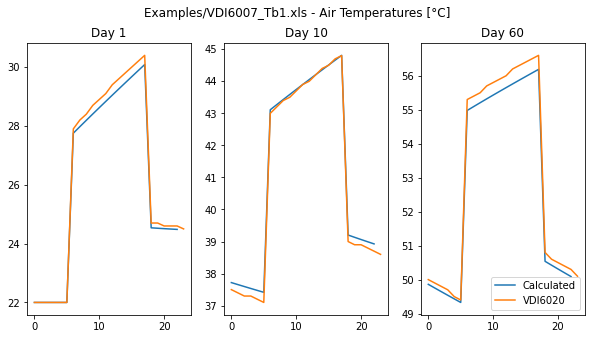

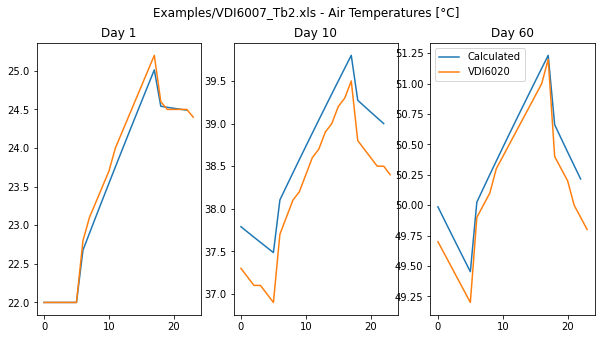

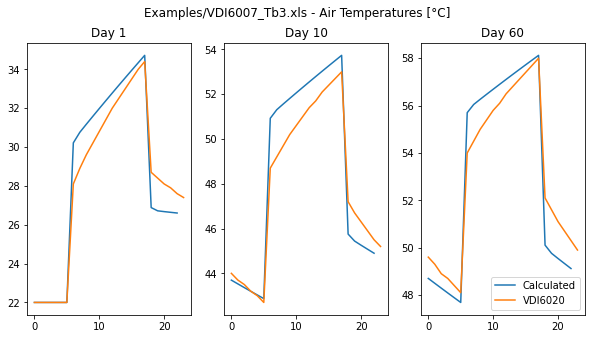

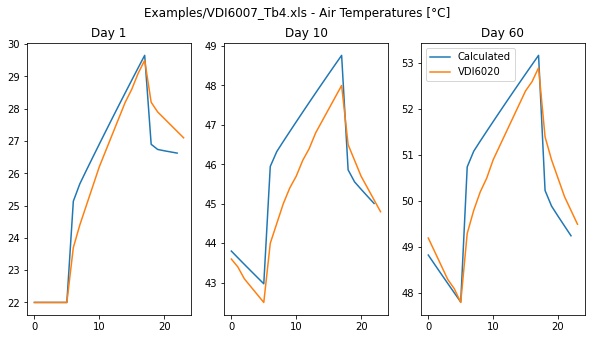

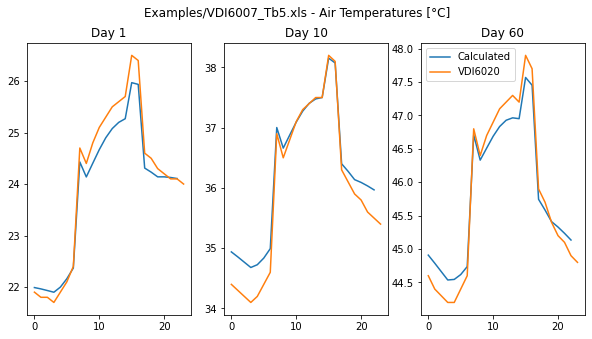

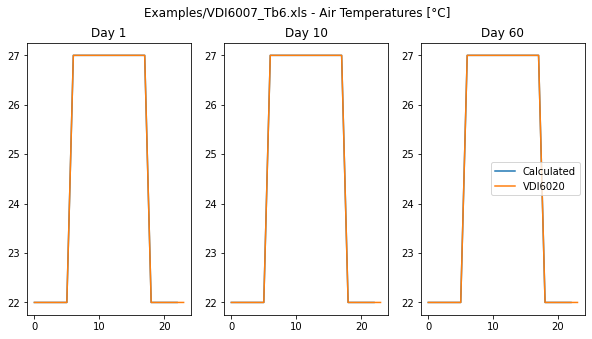

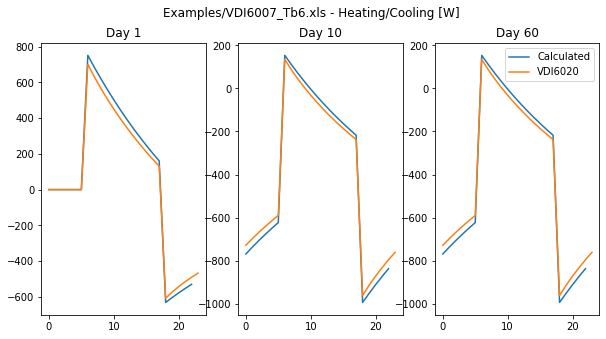

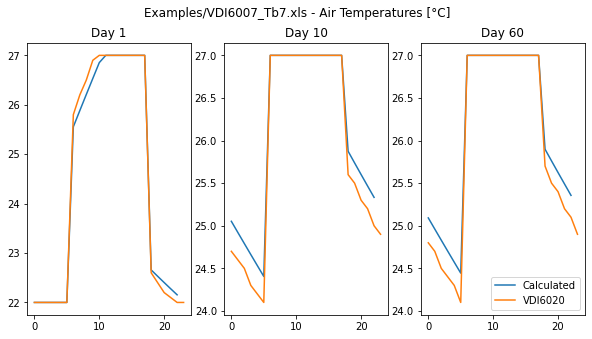

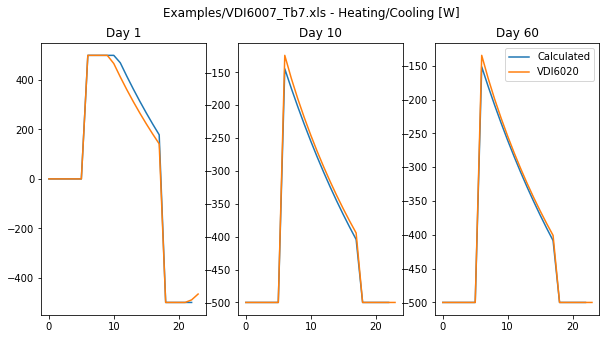

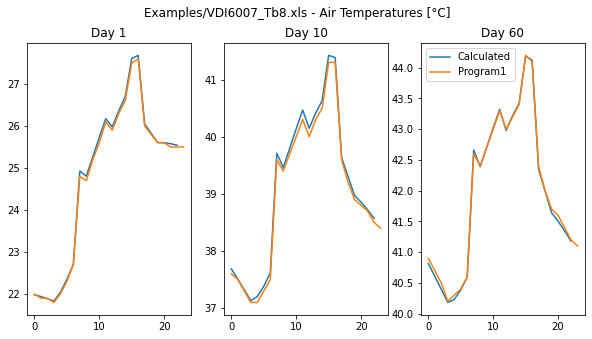

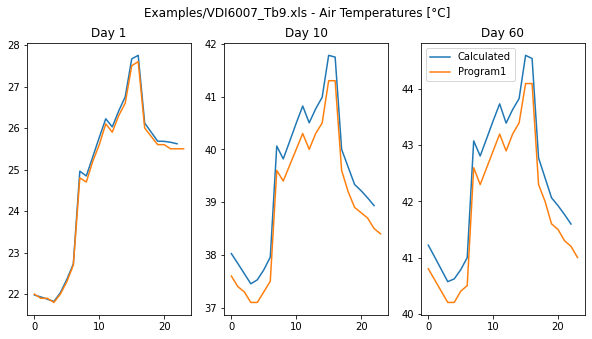

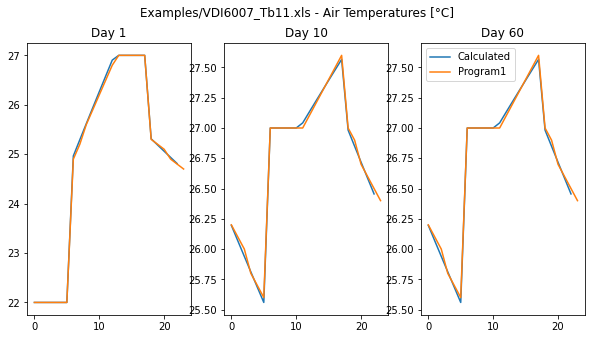

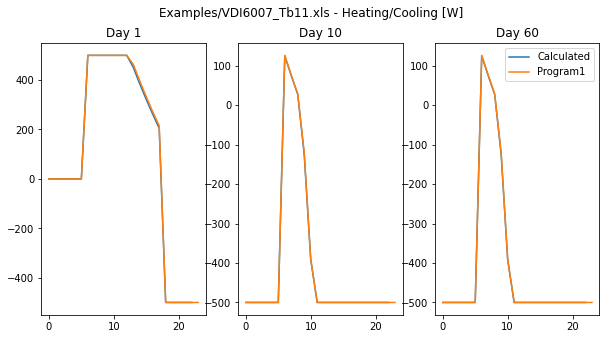

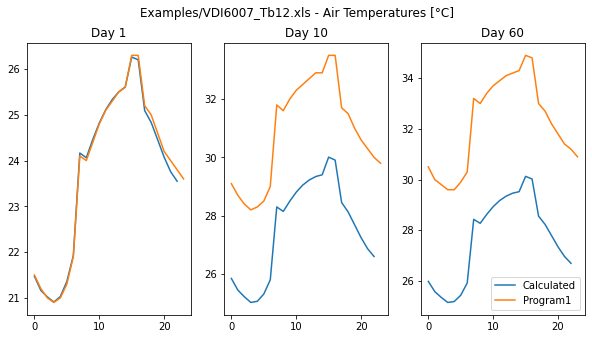

In [6]:
# Run all examples

fname = 'Examples/VDI6007_Tb1.xls'
Run_Example(fname, 'Tlu', 'VDI6020')

fname = 'Examples/VDI6007_Tb2.xls'
Run_Example(fname, 'Tlu', 'VDI6020')

fname = 'Examples/VDI6007_Tb3.xls'
Run_Example(fname, 'Tlu', 'VDI6020')

fname = 'Examples/VDI6007_Tb4.xls'
Run_Example(fname, 'Tlu', 'VDI6020')

fname = 'Examples/VDI6007_Tb5.xls'
Run_Example(fname, 'Tlu', 'VDI6020')

fname = 'Examples/VDI6007_Tb6.xls'
# attention! Input excel seems to have shifted values (27 °C too early) for the set indoor temps 
Run_Example(fname, 'QHK', 'VDI6020')

fname = 'Examples/VDI6007_Tb7.xls'
# attention! Input excel seems to have shifted values (27 °C too early) for the set indoor temps 
Run_Example(fname, 'QHK', 'VDI6020')

fname = 'Examples/VDI6007_Tb8.xls'
# attention! Input excel seems to have mistaken building component names or at least not unique ones
# AF1 and AW1 appear twice and had to be changed to AF2 and AW2
Run_Example(fname, 'Tlu', 'Programs')

fname = 'Examples/VDI6007_Tb9.xls'
# attention! Input excel seems to have mistaken building component names or at least not unique ones
# AF1 and AW1 appear twice and had to be changed to AF2 and AW2
Run_Example(fname, 'Tlu', 'Programs')

fname = 'Examples/VDI6007_Tb11.xls'
# attention! Input excel seems to have shifted values (27 °C too early) for the set indoor temps
Run_Example(fname, 'QHK', 'Programs')

fname = 'Examples/VDI6007_Tb12.xls'
Run_Example(fname, 'Tlu', 'Programs')